In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [8]:
df_patient = pd.read_csv('dataset.csv')
df_patient.shape

(91713, 85)

In [9]:
df_patient.columns

Index(['encounter_id', 'patient_id', 'hospital_id', 'age', 'bmi',
       'elective_surgery', 'ethnicity', 'gender', 'height', 'icu_admit_source',
       'icu_id', 'icu_stay_type', 'icu_type', 'pre_icu_los_days', 'weight',
       'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_post_operative',
       'arf_apache', 'gcs_eyes_apache', 'gcs_motor_apache',
       'gcs_unable_apache', 'gcs_verbal_apache', 'heart_rate_apache',
       'intubated_apache', 'map_apache', 'resprate_apache', 'temp_apache',
       'ventilated_apache', 'd1_diasbp_max', 'd1_diasbp_min',
       'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min',
       'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min',
       'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max',
       'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max',
       'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min',
       'd1_temp_max', 'd1_temp_min', 'h1_diasbp_max', 'h1_diasbp_

* Drop columns 
1. with high correlation and leave the one with lower missing value rate.
2. not intuitive to use for training model.

In [10]:
df_patient.dtypes

encounter_id                     int64
patient_id                       int64
hospital_id                      int64
age                            float64
bmi                            float64
                                ...   
solid_tumor_with_metastasis    float64
apache_3j_bodysystem            object
apache_2_bodysystem             object
Unnamed: 83                    float64
hospital_death                   int64
Length: 85, dtype: object

<AxesSubplot:>

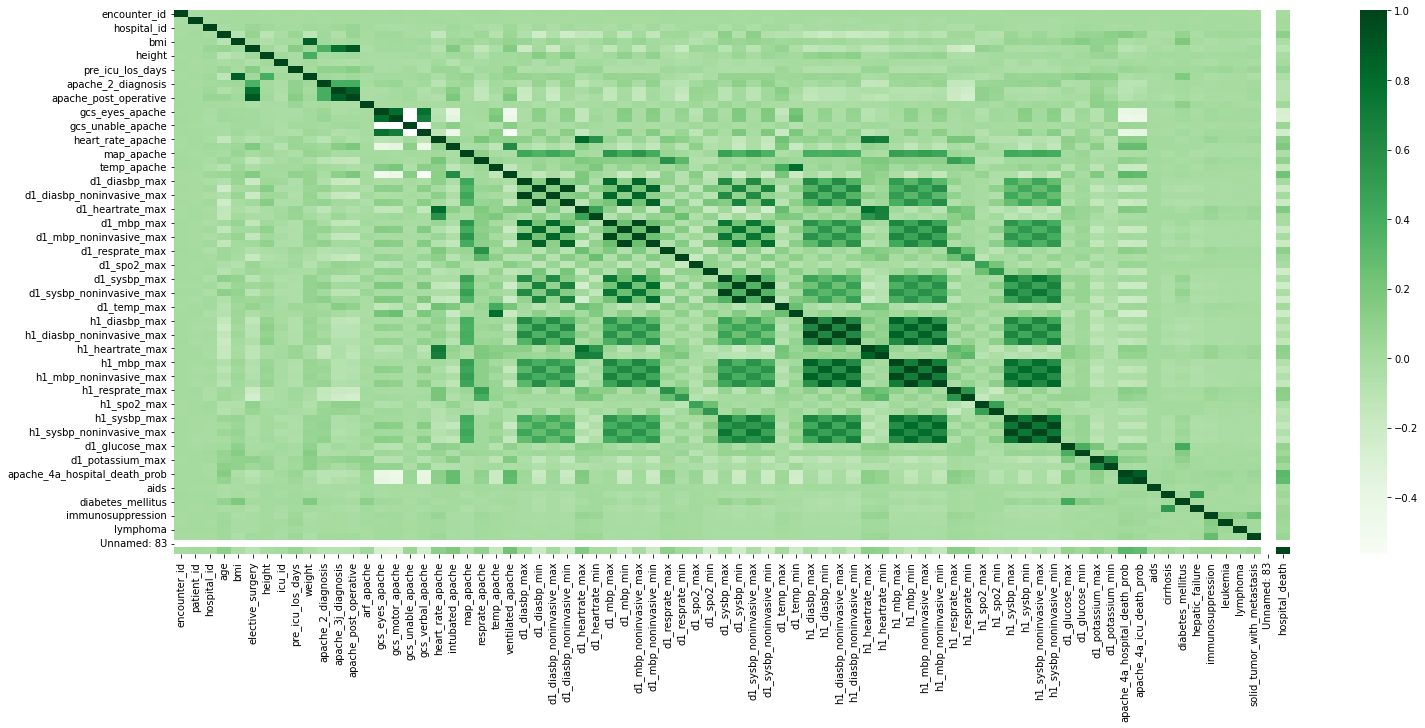

In [11]:
plt.figure(figsize=(25,10))
df_patient_hm = df_patient.drop(columns=['ethnicity', 'gender', 'icu_admit_source',
    'apache_3j_bodysystem', 'apache_2_bodysystem', 'icu_stay_type', 'icu_type'])
sns.heatmap(df_patient_hm.corr(), cmap="Greens")

In [12]:
drop_columns = ['encounter_id', 
    'patient_id', 
    'apache_post_operative',
    'd1_diasbp_noninvasive_max',
    'd1_diasbp_noninvasive_min',
    'd1_mbp_noninvasive_max',
    'd1_mbp_noninvasive_min',
    'd1_sysbp_noninvasive_max',
    'd1_sysbp_noninvasive_min',
    'h1_diasbp_noninvasive_max',
    'h1_diasbp_noninvasive_min',
    'h1_mbp_noninvasive_max',
    'h1_mbp_noninvasive_min',
    'h1_sysbp_noninvasive_max',
    'h1_sysbp_noninvasive_min',
    'apache_4a_hospital_death_prob',
    'apache_3j_bodysystem',
    'Unnamed: 83'
]
df_patient_drop = df_patient.drop(columns=drop_columns)
df_patient_drop.shape

(91713, 67)

* Create a sheet with # of missing value, percentage of missing value and type of columns

In [13]:
df_patient_naSum = pd.DataFrame(df_patient_drop.isna().sum())
df_patient_naSum = df_patient_naSum.set_axis(['missing_number'], axis = 1)
df_patient_naSum = df_patient_naSum.rename_axis('column_name')
df_patient_naSum['missing_percentage'] = df_patient_naSum['missing_number']/(df_patient_drop.shape[0])
df_patient_naSum['type'] = df_patient_drop.dtypes

* Find columns which need to encode

In [14]:
df_object_type = pd.DataFrame(df_patient_naSum[df_patient_naSum['type'] == 'object']['type'])
encode_columns = df_object_type.index.tolist()
print(encode_columns)

['ethnicity', 'gender', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'apache_2_bodysystem']


* As we can see from the dataframe below, we decide to apply label encoding to gender and target encoding to other columns.

In [15]:
category_list = []
for column in encode_columns:
    category_list.append(df_patient_drop[column].nunique())
df_object_type['category_number'] = pd.Series(category_list, index=df_object_type.index)
df_object_type


,type,category_number
column_name,,
ethnicity,object,6
gender,object,2
icu_admit_source,object,5
icu_stay_type,object,3
icu_type,object,8
apache_2_bodysystem,object,10


* Train Test Splitting
1. The target feature is highly unbalanced so a stratified train test split should be used.

In [16]:
df_patient_drop['hospital_death'].value_counts()

0    83798
1     7915
Name: hospital_death, dtype: int64

In [17]:
patient_X = df_patient_drop.drop(columns=['hospital_death'])
patient_y = pd.DataFrame(df_patient_drop['hospital_death'])
patient_X_dev, patient_X_test, patient_y_dev, patient_y_test = train_test_split(patient_X, patient_y, 
    test_size=0.2, random_state=42, stratify=patient_y)
print("Shape of developemnt X set: {}".format(patient_X_dev.shape))
print("Shape of test X set: {}".format(patient_X_test.shape))

Shape of developemnt X set: (73370, 66)
Shape of test X set: (18343, 66)


* Encoding
1. Label Encoding gender
2. Target encoding the rest

In [18]:
le = LabelEncoder()
patient_X_dev['gender'] = le.fit_transform(patient_X_dev['gender'])
patient_X_test['gender'] = le.transform(patient_X_test['gender'])

te = TargetEncoder(cols = ['ethnicity', 
    'icu_admit_source', 
    'icu_stay_type', 
    'icu_type', 
    'apache_2_bodysystem',
    'hospital_id'],
    min_samples_leaf=20, smoothing=10)
patient_X_dev = te.fit_transform(patient_X_dev, patient_y_dev)
patient_X_test = te.transform(patient_X_test, patient_y_test)

* Apply MICE to impute the missing value

In [19]:
imp = IterativeImputer(max_iter=10, random_state=42)
patient_X_dev_temp = imp.fit_transform(patient_X_dev)
patient_X_dev = pd.DataFrame(patient_X_dev_temp, columns = patient_X_dev.columns)
patient_X_test_temp = imp.transform(patient_X_test)
patient_X_test = pd.DataFrame(patient_X_test_temp, columns = patient_X_test.columns)

c:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\impute\_iterative.py:713: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [20]:
for column in patient_X_test.columns:
    if patient_X_test[column].isna().sum() != 0:
        print(column)

* Apply Random oversampling, undersampling, and SMOTE to the development set.

In [21]:
ros = RandomOverSampler(random_state=42)
patient_X_dev_os, patient_y_dev_os = ros.fit_resample(patient_X_dev, patient_y_dev)

print('Lables Count after Random Oversampling: \n', patient_y_dev_os.value_counts())
print('Shape of Development Set: ', patient_X_dev_os.shape)

Lables Count after Random Oversampling: 
 hospital_death
0                 67038
1                 67038
dtype: int64
Shape of Development Set:  (134076, 66)


In [40]:
rus = RandomUnderSampler(random_state=42)
patient_X_dev_us, patient_y_dev_us = rus.fit_resample(patient_X_dev, patient_y_dev)

print('Lables Count after Random Undersampling: \n', patient_y_dev_us.value_counts())
print('Shape of Development Set: ', patient_X_dev_us.shape)

Lables Count after Random Undersampling: 
 hospital_death
0                 6332
1                 6332
dtype: int64
Shape of Development Set:  (12664, 67)


In [22]:
smote = SMOTE(random_state=42)
patient_X_dev_smote, patient_y_dev_smote = smote.fit_resample(patient_X_dev, patient_y_dev)

print('Lables Count after Random Oversampling: \n', patient_y_dev_smote.value_counts())
print('Shape of Development Set: ', patient_X_dev_smote.shape)

Lables Count after Random Oversampling: 
 hospital_death
0                 67038
1                 67038
dtype: int64
Shape of Development Set:  (134076, 66)


* Generate Dataset

In [47]:
scaler = StandardScaler()
scaler.fit(patient_X_dev)
scaler.transform(patient_X_test)

array([[ 0.94701351, -0.64101886,  0.44141428, ..., -0.14499512,
        -0.38877383,         nan],
       [-1.06586156, -0.03466444, -0.08063755, ..., -0.14499512,
        -0.38877383,         nan],
       [ 0.9702362 ,  0.4504191 , -0.23112463, ..., -0.14499512,
         0.68929283, -0.31208242],
       ...,
       [ 0.70835196,  0.20787733, -0.05903392, ..., -0.14499512,
        -0.38877383,         nan],
       [-0.06836743, -1.06546695,  0.37869194, ..., -0.14499512,
        -2.3216182 ,         nan],
       [-0.50368563,  1.29931529, -0.97046436, ..., -0.14499512,
         0.68929283,         nan]])

In [51]:
patient_test = patient_X_test
patient_test['hospital_death'] = patient_y_test
patient_test.to_csv('Data/test.csv', index = False)

In [35]:
patient_dev = patient_X_dev
patient_dev['hospital_death'] = patient_y_dev
patient_dev.to_csv('Data/dev.csv', index = False)

In [36]:
patient_dev_os = patient_X_dev_os
patient_dev_os['hospital_death'] = patient_y_dev_os
patient_dev_os.to_csv('Data/dev_os.csv', index = False)

In [41]:
patient_dev_us = patient_X_dev_us
patient_dev_us['hospital_death'] = patient_y_dev_us
patient_dev_us.to_csv('Data/dev_us.csv', index = False)

In [37]:
patient_dev_smote = patient_X_dev_smote
patient_dev_smote['hospital_death'] = patient_y_dev_smote
patient_dev_smote.to_csv('Data/dev_smote.csv', index = False)